In [380]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [384]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

if False:
    # Paths for Laika
    physDataDir = '/home/svadarevu/gitwork/linear/data/'
    covDataDir = '/home/svadarevu/gitwork/linear/cov/'
    specDataDir = '/kepler/sabarish/data/r590/FF/'
    libDir = '/home/svadarevu/gitwork/linear/library/'
    #sys.path.append('/home/svadarevu/gitwork/linear/library/')
else:
    physDataDir = '/media/sabarish/channelData/R590/phys/'
    specDataDir = '/media/sabarish/channelData/R590/spec/'
    covDataDir =  '/media/sabarish/channelData/R590/cov/'

# Testing CC_AMA code

In [ ]:
os.chdir(libDir)
%run test_minimize.py
#os.chdir(specDataDir)

# Testing the Schur decomposition thingy
## $ Z = BH^* + HB^*$

In [194]:
# The decomposition should work for any Hermitian matrix,
Z = np.random.randn(21,21) + 1.j*np.random.randn(21,21)
Z = Z + Z.conj().T

B,H,S = ops.decomposeZ(Z)
print("Error in the decomposition for some random Hermitian matrix is,",
np.linalg.norm(
    Z - 
    (B @ H.conj().T + H @ B.conj().T),
    ord=2) )

Error in the decomposition for some random Hermitian matrix is, 5.817324301e-14


# Stat completition for turbulent channel flow

In [27]:
# Load turbulent mean for Re=590 from DNS data
#os.chdir(covDataDir)
U0 = np.load(specDataDir+'uMeanN384.npy')
U = np.zeros(U0.size+2)  # Add wall-nodes
U[1:-1] = U0


# Interpolate to a grid with N=64 (internal nodes)
N = 64
Uc = pseudo.chebcoeffs(U)
Uc = Uc[:N+2]
U = pseudo.chebcoll_vec(Uc)
U = U[1:-1] # Lose the wall-nodes



# Initialize statComp instance 
a = 2.; b = 8.; l = a; m = b/2.
statInst = ops.statComp(a=a, b=b, N=N)
# Re-assign attributes U, dU, d2U to reflect turbulent field
statInst.U = U
statInst.dU = statInst.D1 @ U
statInst.d2U = statInst.D2 @ U




Initialized instance of 'linearize', version 4.2.
New in this version: diffmats and OSS validated for channel and BL LSA. 
Re is now a class attribute. Use the appropriate one depending on what velocity is used for scaling U,dU,d2U.
To fix: channel routines in pseudo.py to ignore wall-nodes, 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loaded matrix from /media/sabarish/channelData/R590/cov/covR590N64l02m04.npy ...
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


In [52]:
outStats = statInst.completeStats(iterMax=10,tolPrimal=1.0e-04,tolDual=1.0e-04,savePath='../')

/home/sabarish/Dropbox/melb/code/library/ops.py:300: UserWarning: z,w represent wall-normal, and y,v represent spanwise.
  warn("z,w represent wall-normal, and y,v represent spanwise.")
/home/sabarish/Dropbox/melb/code/library/minimize.py:53: UserWarning: Be careful with array multiplication. All arrays are now matrices, so A*B is matrix multiplication, not elementwise multiplication.
  
/home/sabarish/Dropbox/melb/code/library/minimize.py:91: UserWarning: No Z0 supplied, using identity...
  Z0 = np.identity(nState , dtype=dynMat.dtype )
/home/sabarish/Dropbox/melb/code/library/minimize.py:94: UserWarning: No X0 supplied, solving Lyapunov equation with Z0
  X0 = solve_lyapunov( dynMat, -Z0 )
/home/sabarish/Dropbox/melb/code/library/minimize.py:99: UserWarning: No Y10 supplied, solving adjoing Lyapunov equation
  Y10 = solve_lyapunov( dynMat.H, X0)
/home/sabarish/Dropbox/melb/code/library/minimize.py:102: UserWarning: Y10 from solve_lyapunov does not have attribute 'H', so it's an ndarr

Write decorators for timing and logging (have a look at your bookmarks on Chrome)

Starting iterations for AMA......
stepSize_BB  stepSize  tolPrimal   resPrimal  tolDual   abs(dualGap)    iter
      10  9.31e-09      0.0001     1.7e+04      0.0001  1.3e+02  0


/home/sabarish/Dropbox/melb/code/library/minimize.py:300: ComplexWarning: Casting complex values to real discards the imaginary part
  funDualArr[AMAstep] = np.real(dualYnew)


saved statistics to  ../outStatsR10000N64a02b08.hdf5


In [ ]:
uff0 = miscUtil.bin2arr(specDataDir+'uFF_it45000.dat')
uffRealSum = uff0.copy().real
uffAbsSum = np.abs(uff0.copy())
for t in range(45500,75500,500):
    uff = miscUtil.bin2arr(specDataDir+'uFF_it%d.dat'%t)
    uffRealSum += uff.real
    uffAbsSum += np.abs(uff)
uffRealSum = uffRealSum/301.
uffAbsSum  = uffAbsSum/301.
z = pseudo.chebdif(386,1)[0][1:-1]
#plt.plot(z, uffRealSum, z, uffAbsSum)
#plt.show()

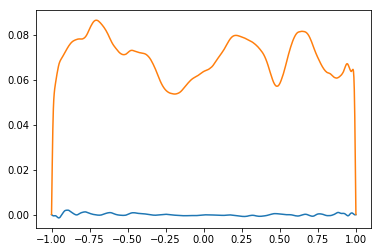

In [32]:
plt.plot(z, uffRealSum[2,0], z, uffAbsSum[2,0])
plt.show()

# Covariance matrices from DNS

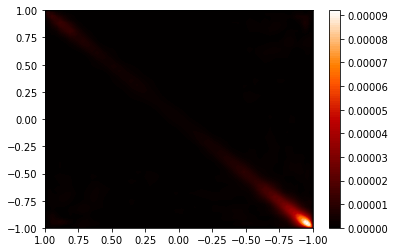

In [8]:
N = 64
covMat =np.load(covDataDir+'covR590N%dl08m10.npy'%N)
z = pseudo.chebdif(N+2,1)[0][1:-1]
plt.contourf(z, z,np.abs(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('gist_heat'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()
#print(np.diag(covMat[:N,:N]))

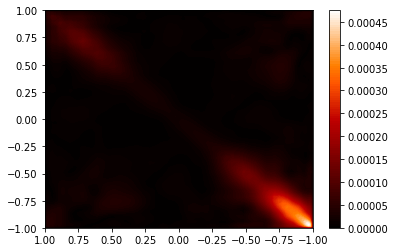

In [4]:
N = 64
covMat =np.load(covDataDir+'covR590N%dl02m05.npy'%N)
z = pseudo.chebdif(N+2,1)[0][1:-1]
plt.contourf(z, z,np.abs(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('gist_heat'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()
#print(np.diag(covMat[:N,:N]))

# Premultiplied energy spectrum

In [ ]:
a = 1.
lArr = np.arange(1., 65.)
mArr = np.arange(64.)
N = 64
energyArr = np.zeros((lArr.size+1, N))
premulEnergyArr = energyArr.copy()
for l in lArr:
    kx = l*a
    for m in mArr:
        covMat = np.load(covDataDir + 'covR590N64l%02dm%02d.npy'%(l,m))
        energyArr[int(l)] += np.diag(np.abs(covMat[:N,:N]))
    
    premulEnergyArr[int(l)] = kx*energyArr[int(l)]
z = pseudo.chebdif(N+2,0)[0][1:-1]
plt.contourf(lArr[1:], z, premulEnergyArr.T)
plt.colorbar()
plt.show()
    
    
    

(64, 64) (63,) (384,)


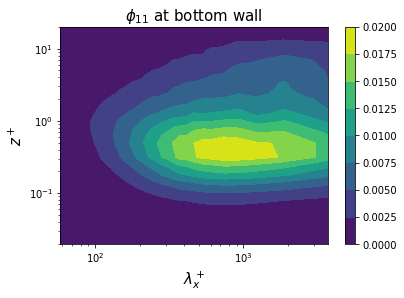

In [53]:
print(premulEnergyArr[1:].T.shape,lArr[1:].shape, z.shape)
phi11 = premulEnergyArr[1:, :-33:-1]
plt.contourf(590.*2.*np.pi/lArr, 590.*(1.-z[:32]), phi11.T)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$\lambda_x^+$',fontsize=15); plt.ylabel('$z^+$',fontsize=15)
plt.title('$\phi_{11}$ at bottom wall',fontsize=15)
plt.colorbar()
plt.show()

(64, 64) (63,) (384,)


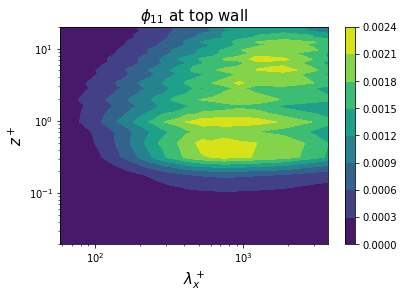

In [54]:
print(premulEnergyArr[1:].T.shape,lArr[1:].shape, z.shape)
phi11 = premulEnergyArr[1:, :32]
plt.contourf(590.*2.*np.pi/lArr, 590.*(1.-z[:32]), phi11.T)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$\lambda_x^+$',fontsize=15); plt.ylabel('$z^+$',fontsize=15)
plt.title('$\phi_{11}$ at top wall',fontsize=15)
plt.colorbar()
plt.show()

# Testing phys2spec

In [69]:
%timeit miscUtil.phys2spec(t=74950,L=32,M=24)

Successfully FFTd ./u_it74950.dat to ./uFF_it74950.dat
Successfully FFTd ./v_it74950.dat to ./vFF_it74950.dat
Successfully FFTd ./w_it74950.dat to ./wFF_it74950.dat
Successfully FFTd ./u_it74950.dat to ./uFF_it74950.dat
Successfully FFTd ./v_it74950.dat to ./vFF_it74950.dat
Successfully FFTd ./w_it74950.dat to ./wFF_it74950.dat
Successfully FFTd ./u_it74950.dat to ./uFF_it74950.dat
Successfully FFTd ./v_it74950.dat to ./vFF_it74950.dat
Successfully FFTd ./w_it74950.dat to ./wFF_it74950.dat
Successfully FFTd ./u_it74950.dat to ./uFF_it74950.dat
Successfully FFTd ./v_it74950.dat to ./vFF_it74950.dat
Successfully FFTd ./w_it74950.dat to ./wFF_it74950.dat
1 loop, best of 3: 4.59 s per loop


/home/svadarevu/linenv/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


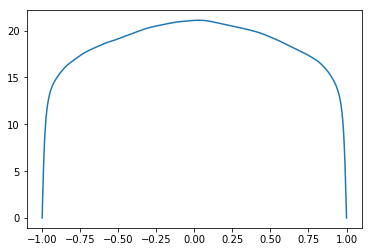

In [68]:
uArr = miscUtil.bin2arr('uFF_it74950.dat',L=32,M=24,N=384)
z = pseudo.chebdif(N,1)[0]
plt.plot(z,uArr[0,0]); plt.show()